# Производство молока

Датасет <a href="https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line">Monthly milk production: pounds per cow. Jan 62 – Dec 75</a>  — данные по ежемесячному уровню производства молока в фунтах на одну корову с января 1962 по декабрь 1975

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


C:\Users\User\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# обрабтное преобразование Бокса-Кокса

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [18]:
data = pd.read_csv('monthly-milk-production-pounds-p.csv',',', index_col=['Month'], parse_dates=['Month'], dayfirst=True)
data.head()

,Pounds
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [19]:
data.index = pd.to_datetime(data.index, format='%Y-%m')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
Pounds    168 non-null int64
dtypes: int64(1)
memory usage: 2.6 KB


### Визуальный анализ

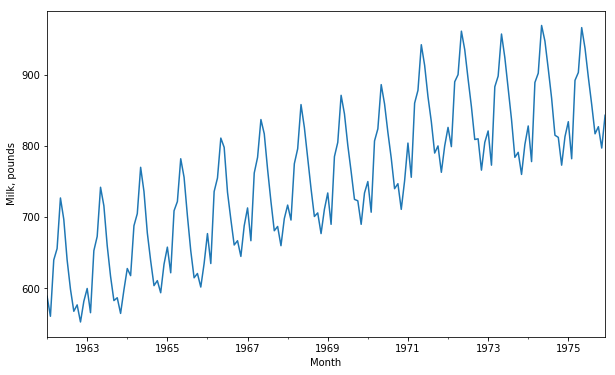

In [20]:
plt.figure(figsize(10,6))
data.Pounds.plot()
plt.ylabel('Milk, pounds')
pylab.show()

Поделим ряд с объёмом производства молока на одну корову на число дней в месяце, полученная величина будет меняться более плавно, и для неё легче будет построить прогнозирующую модель 

In [22]:
data['daily'] = data.Pounds/data.index.days_in_month

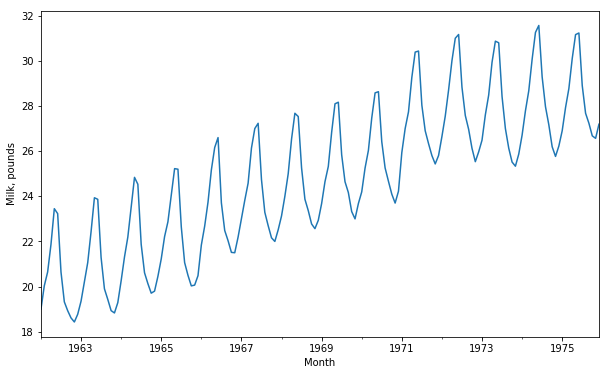

In [23]:
plt.figure(figsize(10,6))
data.daily.plot()
plt.ylabel('Milk, pounds')
pylab.show()

### Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.879938
Критерий Дики-Фуллера: p=0.663615


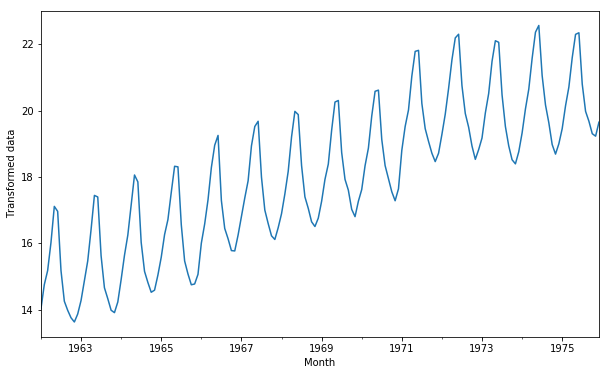

In [24]:
data['boxcox'], lmbda = stats.boxcox(data.daily)
plt.figure(figsize(10,6))
data.boxcox.plot()
plt.ylabel(u'Transformed data')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.boxcox)[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, визуально в данных виден тренд

### Стационарность

Применим сезонное дифференцирование

Критерий Дики-Фуллера: p=0.217894


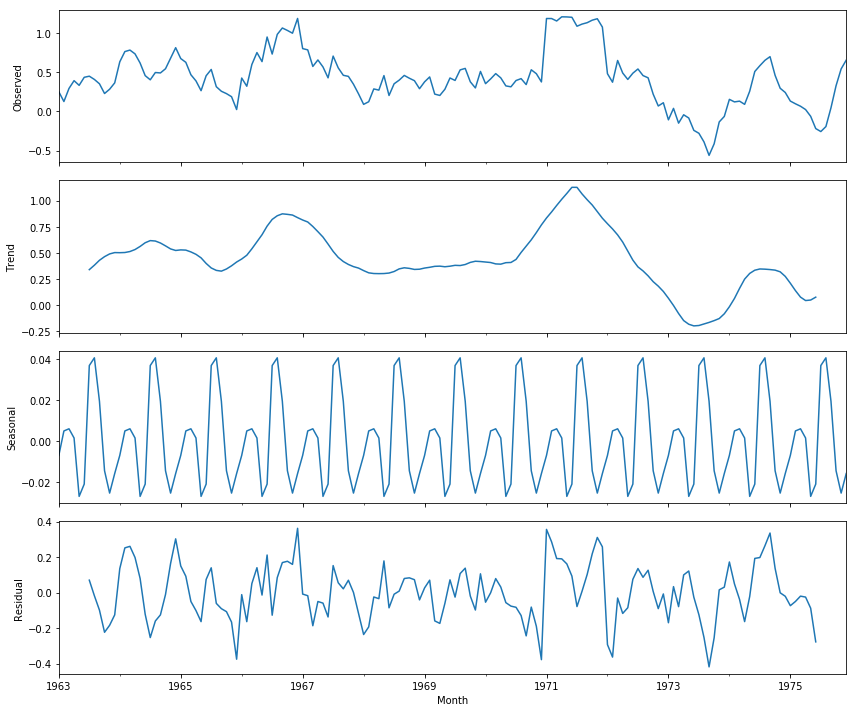

In [25]:
data['season_diff'] = data.boxcox - data.boxcox.shift(12)
plt.figure(figsize(12,10))
sm.tsa.seasonal_decompose(data.season_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.season_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности. Попробуем добавить ещё обычное дифференцирование

Критерий Дики-Фуллера: p=0.000003


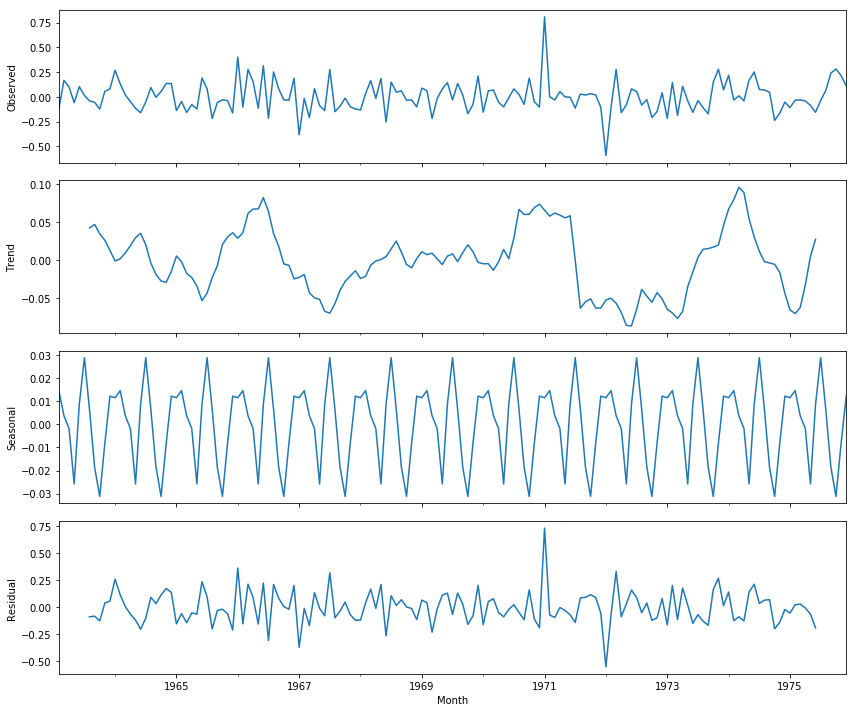

In [26]:
data['diff2'] = data.season_diff - data.season_diff.shift(1)
plt.figure(figsize(12,10))
sm.tsa.seasonal_decompose(data.diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.diff2[13:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, дальше работаем с преобразованным рядом

### Выбор начальных приближений для p, q, P, Q

Посмотрим на автокорреляционную и частичную автокорреляционную функции ряда

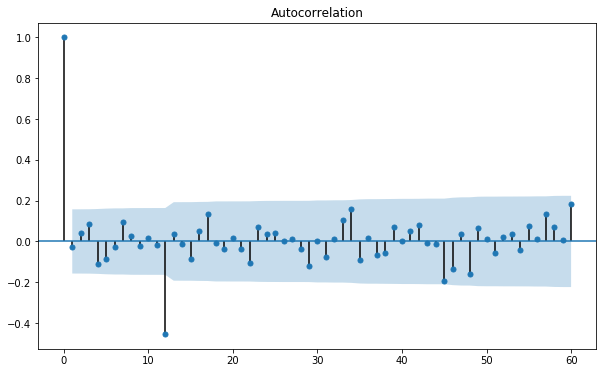

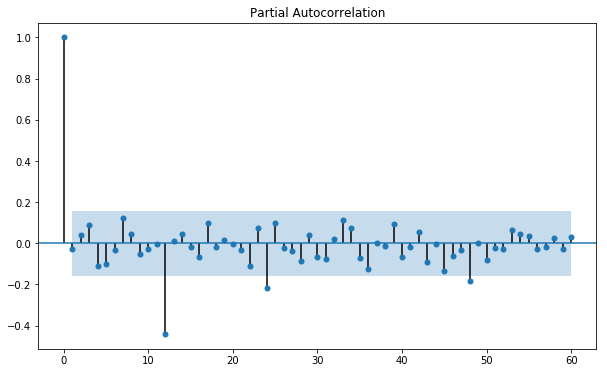

In [30]:
plt.figure(figsize(10,6))
ax = plt.subplot()
sm.graphics.tsa.plot_acf(data.diff2[13:].values.squeeze(), lags=60, ax=ax)
pylab.show()
ax = plt.subplot()
sm.graphics.tsa.plot_pacf(data.diff2[13:].values.squeeze(), lags=60, ax=ax)
pylab.show()

In [31]:
# Начальные приближения: Q=1, q=0, P=4, p=0

p = 0
d = 1
q = 0
Ps = range(0, 4)
D = 1
Qs = range(0, 1)

parameters = product(Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

4

Обучение и сравнение моделей-кандидатов, выбор победителя

In [32]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.boxcox, order=(p, d, q), 
                                        seasonal_order=(param[0], D, param[1], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    except LinAlgError:
        print 'wrong parameters (LinAlgError):', param
        continue     
    aic = model.aic

    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0))
Wall time: 6.33 s


In [33]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
2     (3, 0) -171.409093
1     (2, 0) -171.356601
0     (1, 0) -165.473382


In [34]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             boxcox   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(3, 1, 0, 12)   Log Likelihood                  89.705
Date:                            Tue, 19 Jun 2018   AIC                           -171.409
Time:                                    17:09:22   BIC                           -158.913
Sample:                                01-01-1962   HQIC                          -166.338
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6129      0.095     -6.486      0.000      -0.798      -0.428
ar.S.L24      -0.2963      0.087   

### Анализ остатков построенной модели

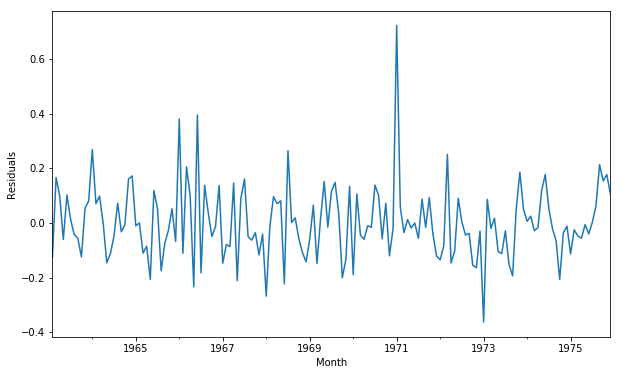

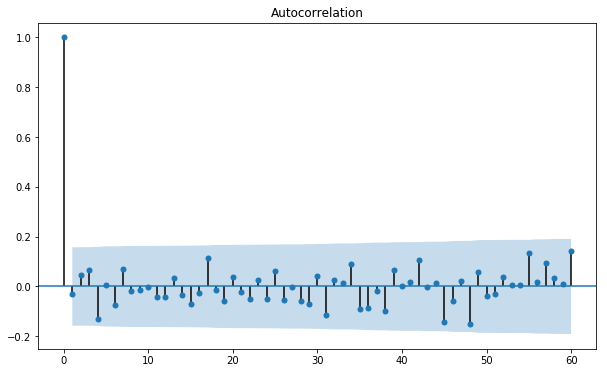

Критерий Стьюдента: p=0.902012
Критерий Дики-Фуллера: p=0.000000


In [36]:
plt.figure(figsize(10,6))
plt.subplot()
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
plt.show()

ax = plt.subplot()
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=60, ax=ax)
plt.show()

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

По критериям Стьюдента и Дики-Фуллера остатки несмещены и стационарны, неавтокорелированны (по кореллограмме)

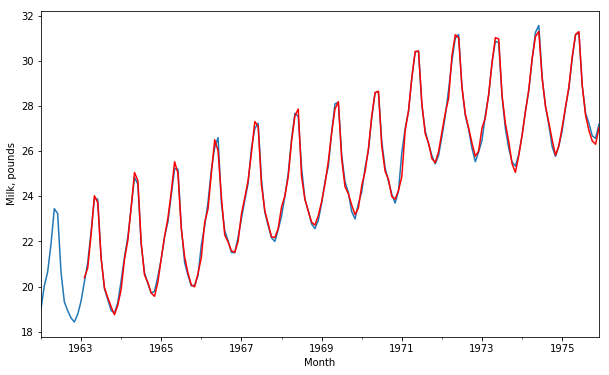

In [40]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(10,6))
data.daily.plot()
data.model[13:].plot(color='r')
plt.ylabel('Milk, pounds')
plt.show()

Построенная модель неплохо приближает исходный ряд

### Прогноз

Сделаем прогноз для следующих 3х лет производства молока

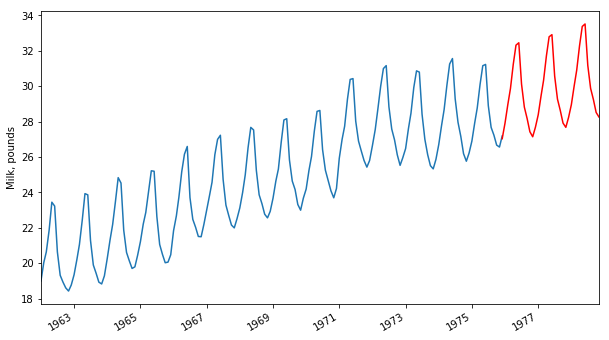

In [48]:
data2 = data[['daily']]
date_list = [datetime.datetime.strptime("1975-12-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0, 36)]
future = pd.DataFrame(index=date_list, columns=data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=data.shape[0]-1, end=data.shape[0]+3*12), lmbda)

plt.figure(figsize(10,6))
data2.daily.plot()
data2.forecast.plot(color='r')
plt.ylabel('Milk, pounds')
plt.show()